# SICSS-IAS 2025: Computational Text Analysis (SOLUTIONS)

> Hendrik Erz, IAS | <hendrik.erz@liu.se> | Bluesky: [@hendrik-erz.de](https://bsky.app/profile/hendrik-erz.de)
> 
> Alexandra Rottenkolber, IAS | <alexandra.rottenkolber@liu.se> | Bluesky: [@alexandrartnk.bsky.social](https://bsky.app/profile/alexandrartnk.bsky.social)
>
> Diletta Goglia, Uppsala University | <diletta.goglia@it.uu.se> | Bluesky: [@dilettagoglia.bsky.social](https://bsky.app/profile/dilettagoglia.bsky.social)

Welcome to the practical part of the Computational Text Analaysis day! In this notebook, you will try out some of the methods covered in the morning lecture. In particular, the methods covered will be:

* tf-idf scores
* topic modeling
* Word2Vec

Below, you will see several exercises that cover most of the steps from an unprocessed text corpus to a final trained model. As a default choice, we provide a corpus of the [**U.S. State of the Union (SOTU)**](https://en.wikipedia.org/wiki/State_of_the_Union) speeches, but you are welcome to use your own corpus. The code is agnostic to the data used and should work with everything.

You will work on these examples in smaller groups with guidance from us.

## I want to use my own corpus!

If you want to use your own corpus, that's great! However, it should fulfill certain criteria so that the methods make sense. If your corpus does not fulfill these criteria, some or all of these methods may still apply, but additional tweaks to the parameters may be necessary. **If you are uncertain, just ask! :)**

* The corpus should at least contain 100 documents (and probably not more than 10,000)
* Tweets are probably too short. Aim for about 300-1,200 words per document. (A few too short or too long documents don't matter, as long as most of them fall in the range.)
* The corpus should be in a language that uses individual characters that are combined to form words (read: western scripts), so scripts such as Chinese, Korean, or Japanese may not work with these methods
* The corpus should be formed from a single source (i.e. same language, same type of document, etc.)

## Preliminaries: Installing the necessary packages

This workbook relies on a set of packages. Depending on what package manager you use, there are various ways to install them (e.g., with Conda, pip, or virtualenv).

Make sure to install them according to how you have set up Python. If you use plain `pip`, here is how you can install them:

```bash
python -m pip install pandas       # For creating DataFrames
python -m pip install numpy        # For numerical operations, specifically matrices
python -m pip install gensim       # Used for the word2vec model
python -m pip install scikit-learn # Contains the tf-idf and Latent Dirichlet Allocation models
python -m pip install nltk         # Offers word- and sentence tokenizers as well as stopword lists
python -m pip install matplotlib   # For plotting, similar to ggplot in R
```

**Since these will come in handy, here is also a list of all manuals for the respective packages:**

* [pandas](https://pandas.pydata.org/docs/)
* [numpy](https://numpy.org/doc/1.24/reference/index.html)
* [gensim](https://radimrehurek.com/gensim/auto_examples/index.html)
* [scikit-learn](https://scikit-learn.org/stable/user_guide.html)
* [nltk](https://www.nltk.org/)
* [matplotlib](https://matplotlib.org/stable/users/index)

> [!NOTE]
> Many Python packages require certain build-tools to be available on your
> system, including C and Fortran compilers, or CMake. The reason is that some
> packages want to compile their dependencies on your computer. By running this
> notebook on a platform such as Google Colab, you can avoid this as they
> usually do all of this in the background, but if you plan on working locally,
> you may have to install those packages manually.

## Loading the Corpus

The first step you'll have to do is load the corpus. How you are loading the corpus heavily depends on the data format in which it is stored. The demo-corpus is stored as a TSV-file (tab-separated values). TSV-files are a very common way to store textual data, since tab-characters have no linguistic meaning, and therefore can be used as separators of the fields.

Your task in this exercise is to write a function that will return parts of the corpus in a way that the models we are using works with.

***

We will use a [**generator**](https://wiki.python.org/moin/Generators) to load our corpus, since a generator helps us keep the memory footprint small and therefore to keep the model training times low. For our small corpus, this may seem over-engineered, but most corpora are too large to be loaded at once, so it is important to learn this technique early.

> If you want to learn more about why generators are useful to us as social scientists, [click here](https://www.hendrik-erz.de/post/what-is-a-generator).

Your function should `yield` the speeches one after another:

```python
corpus = [
    ('Speech Title', 'Author name', 'date', 'This is the first speech'),
    ('Speech Title', 'Second author', 'date', 'This is a second speech'),
    # ...
]
```

The corpus contains additional metadata that you can use if you wish to explore it further. The additional data should be returned here so that you have it available if you need it.

**Whenever you need the speeches, just call `speeches()` in your code. The speech text is accessible from each tuple at the third index (`speech[3]`).**

### Exercise 1: Load the Corpus

Below, write a function that reads in the corpus. Remember to use a generator (`yield` instead of `return`) and to return tuples of `(title, author, date, text)`.

In [1]:
def speeches ():
  """A generator that yields (title, author, date, text) tuples"""
  # NOTE: Ensure that the file `sotu.tsv` is in the same directory as this notebook.
  with open("sotu.tsv", "r", encoding="utf-8") as fp:
    next(fp) # Skip the header line: title, author, date, text
    for line in fp:
      title, author, date, text = line.strip().split('\t')
      yield (title, author, date, text)

In [2]:
# Run this cell to ensure your function works properly and returns 251 speeches.
assert sum([1 for x in speeches()]) == 251, "Wrong number of speeches!"

## Getting to Know the Corpus

Now that we have access to the text in the corpus, we should make sure we have some bearings in the corpus. For this, a very simple method is to simply start counting words. This is not necessarily the most informative method, but it will give us some data that we can use to make some sense of the corpus. Additionally, it is extremely fast and therefore cheap to do.

Getting to some word counts involves just two steps:

1. First, we need a **tokenizer** that can split up a speech into tokens.
2. With speeches tokenized into individual words, we can count those.

### Exercise 2: Write a text tokenizer

Below, write a function that takes a single speech and returns a list of tokens within this speech. You should remove digits, punctuation marks, and other symbols that do not comprise regular, English words. Also, ensure that capitalization of letters does not matter by transforming the speech into lower case first.

> TIP: The NLTK package offers a lot of useful functions for working with natural language. It includes functions to remove stopwords and to tokenize a text. Also, the String class of Python provides additional easy functions you can use. Have a look at the documentation for [**nltk.corpus**](https://www.nltk.org/api/nltk.corpus.html) and [**nltk.tokenize**](https://www.nltk.org/api/nltk.tokenize.html).

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Loads a common english stopword list
stops = stopwords.words('english')

def tokenize_speech(speech):
  """Takes a single speech (string of text) and returns a list of all proper words contained within this speech."""
  return [t for t in word_tokenize(speech.lower()) if t.isalpha() and t not in stops]

In [4]:
stops

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
# Run this cell to see how the preprocessor processes the first speech.
first_speech = next(speeches())
tokenize_speech(first_speech[3])[0:10] # Look at the first ten words

['speaker',
 'president',
 'distinguished',
 'members',
 'house',
 'senate',
 'first',
 'met',
 'years',
 'us']

### Exercise 3: Count words

Now that we have a way to tokenize our speeches, we can count the words inside our corpus.

Counting words in Python is very easy, since it has a useful function for us: [`Counter`](https://docs.python.org/3/library/collections.html#collections.Counter).

> Below, write a function that counts the word frequencies of the entire corpus and returns a list of elements. Hint: The Counter class provides a handy method called `most_common`.

In [6]:
from collections import Counter

def count_words ():
  """Returns a list of tuples that contain the words in the corpus and their frequency."""
  word_counter = Counter()
  for speech in speeches():
    word_counter.update(tokenize_speech(speech[3]))
  return word_counter.most_common()

In [7]:
# Let us now look at the ten most common, and then ten least common words:

words = count_words()

print("Most common words:")
print(words[0:10])

print("")
print("Least common words:")
print(words[-10:])

Most common words:
[('government', 7652), ('states', 6990), ('congress', 5947), ('united', 5202), ('year', 4848), ('people', 4527), ('would', 4347), ('upon', 4254), ('country', 3734), ('must', 3721)]

Least common words:
[('intrench', 1), ('prophetic', 1), ('seasoned', 1), ('inured', 1), ('afflictive', 1), ('sires', 1), ('penned', 1), ('glancing', 1), ('vestments', 1), ('clod', 1)]


### Verify Zipf's Law

One great way of ensuring that your corpus does not include oddities and spurious data, a very simple verification involves checking for Zipf's law: The fact that a few words are very common, and many words are relatively uncommon. A histogram of words should resemple a logarithmic function.

Below, plot the frequencies ordered by rank.

> Note: If you are stuck, the matplotlib documentation has got you covered. Just make sure to plot the word frequencies against their rank, which involves sorting the list. Remember to set the y-axis scale to logarithmic and provide proper labels.

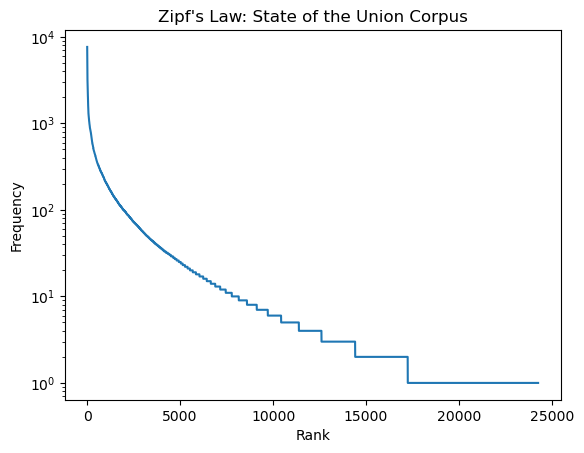

In [8]:
import matplotlib.pyplot as plt

# Extract only the actual numbers, and sort them by size descending.
word_counts = sorted(list(map(lambda x: x[1], words)), reverse=True)

plt.plot(range(len(word_counts)), word_counts)
plt.yscale("log") # Set the Y-axis to a logarithmic scale.
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.title("Zipf's Law: State of the Union Corpus")
plt.show()

## Computing tf-idf scores

Word frequency counts are simple and straightforward, but do not say anything about the importance of words. The most common word of the English language, "the", will therefore always show up at the top of the distribution, but the word is not really informative. An improvement over simple word counts is tf-idf, or term-frequency, inverse document-frequency, which penalizes words that occur often across all documents, but increases the score for rare words that occur frequently in only some documents.

Calculating tf-idf scores can be done "manually" as this only involves re-weighting the terms, but for practical usage, there are some libraries that already do that for you.

Calculating tf-idf scores consists of three steps:

1. Calculate the term frequencies of words within each document
2. Calculate the inverse document frequency for each word
3. For each word in each document, calculate tf-idf by multiplying the document-specific frequency with the word's IDF-score

### Exercise 4: Build a Vocabulary

For tf-idf scores, it makes sense to manually build a vocabulary beforehand. While calculating tf-idf scores does not require a vocabulary, it gives us control over what words should even be included in the calculation, and makes it easier to analyze which words received which scores. Additionally, we will need a vocabulary for our next method, LDA topic models, so it makes sense to create one here.

Creating a manual vocabulary has a few advantages over letting the packages handle it: first, you can easily filter it before providing it to text analysis models, ensuring that you only use words you want to. Second, you can inspect it to detect potential issues in your corpus (e.g., hard to detect but frequent typos that may hamper the analyses). Third, it makes the process of using the vocabulary transparent.

The easiest form of a vocabulary is a dictionary that maps words to indices:

```python
vocab = {
    'word': 0,
    'word2': 1,
    # ...
}
```

Since we also need to figure out words by their indices after running some of our methods, we should create a so-called `i2w`-dictionary. The `i2w` ("index to word") performs the reverse lookup and maps indices to words:

```python
iw2 = {
    0: 'word',
    1: 'word2',
    # ...
}
```

> Nerd fact: If you are curious why we would want to create two dictionaries: the main reason for this is performance. Dictionaries in Python are implemented as [hash tables](https://en.wikipedia.org/wiki/Hash_table), so looking up indices and words is almost instantaneous, which makes this method much faster than ordinary lists.

We can then use these dictionaries to retrieve indices or words, depending on what we need:

```python
idx = vocab['president']
# > May yield '24'

word = i2w[24]
# > May yield 'president'
```

Below, write a function that returns both a vocab and an i2w.

In [9]:
def build_vocab ():
  # First generate the word -> index mapping
  vocab = {}
  for speech in speeches():
    for token in tokenize_speech(speech[3]):
      if not token in vocab:
        # This basically adds unseen words to the end of the vocabulary
        vocab[token] = len(vocab)

  # Now reverse it (important later), i.e. index -> word mapping.
  # i2w = index2word
  i2w = {}
  for token in vocab:
    i2w[vocab[token]] = token

  return vocab, i2w

In [10]:
# Run this cell to create the vocabulary
vocab, i2w = build_vocab()

In [11]:
# Let us have a first look at the first ten words in our vocabulary. Note how
# the first ten words in our vocab equal the first words of the first speech
# (sans stopwords, numbers, etc).
list(vocab.keys())[0:10]

['speaker',
 'president',
 'distinguished',
 'members',
 'house',
 'senate',
 'first',
 'met',
 'years',
 'us']

### Exercise 5: Calculate tf-idf scores

Now that we have a vocabulary, we can calculate the tf-idf scores. Below, write a function that calculates tf-idf scores for our corpus and then outputs the most relevant word for each speech.

> The library `scikit-learn` has a useful function for that called `TfidfVectorizer`. You will need to pass it the vocabulary and the speeches. Note additionally that the `TfidfVectorizer` will by default normalize the scores, so ther values will be different (but they will have the same ordering).

The data will be returned in the following form, which is, as you can see, a document-term matrix where each row corresponds to a document, and each column corresponds to a word. The cell contents contain the tf-idf score for the given word in the given document. This is why we have created a vocabulary and an `i2w` beforehand: This way you can map the column-index back to the proper words. In other words: If the most important word for a document is at index 23, we can call `i2w[23]` to find out the corresponding word.

```python
tfidf = [
  # Document 1
  [
    0.23,
    0.11,
    # ...
  ],
  # Document 2
  [
    0.412,
    0.0012,
    # ...
  ],
  # ...
]
```

As an additional hint: The models that scikit-learn provides all share a common format that is intended to be used as such:

1. Instantiate a new model, providing your settings for the model
2. Provide data and `fit` the model to the data
3. `transform` a set of data using the fitted model, which will return a document-term matrix (DTM) where each column corresponds to a term, and each row to a document. The cell then contains the actual scores.

> Note that the function `fit_transform` performs steps 2 and 3 at the same time, which is sufficient for this exercise.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_tf_idf ():
  vocab, _ = build_vocab()
  tfidf = TfidfVectorizer(vocabulary=vocab, tokenizer=tokenize_speech)
  text = [speech[3] for speech in speeches()]
  # NOTE: fit_transform returns a DTM of size (n_documents x n_words) where each
  # cell contains the corresponding tf-idf score.
  document_term_matrix = tfidf.fit_transform(text)
  return document_term_matrix

In [13]:
# Call the function to calculate the tf-idf scores
tf_idf = calculate_tf_idf()

/opt/homebrew/Caskroom/miniforge/base/envs/nlpbert/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Exercise 6: Analysis of tf-idf scores

Now that we have calculated tf-idf scores, it is time to have a look at them. Since we have already transformed them into an easily digestible format, this step code should be relatively simple. Below, write code to print out the highest scoring word for each speech, as well as, afterwards, the lowest-scoring word.

> In order to do so, you need to iterate over all documents, and for each document find the word that has the highest and the lowest tf-idf score. An easy way to do so is to take an entire row (i.e. all terms) and utilize the functions [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) and [`np.argmin`](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html), which return not the `max` or `min` _values_ of them (the tf-idf scores), but rather the _index_ at which the max/min values are. Then you can look up the word that corresponds to that index with the `i2w` score.

Explain what makes the words important or unimportant, and what this means in the context of the SOTU corpus.

In [14]:
import numpy as np

n_documents = tf_idf.shape[0]

print("Most important words (according to tf-idf):")
words = list()
for doc in range(n_documents):
  max_word_idx = np.argmax(tf_idf[doc])
  words.append(i2w[max_word_idx])
print(", ".join(set(words))) # Creating a set removes duplicate words

print("")
print("Least important words (according to tf-idf):")
words = list()
for doc in range(n_documents):
  max_word_idx = np.argmin(tf_idf[doc])
  words.append(i2w[max_word_idx])
print(", ".join(set(words))) # Creating a set removes duplicate words

Most important words (according to tf-idf):
know, environmental, vietnam, blockades, emancipation, hussein, soviet, coinage, british, america, industrial, megan, slavery, may, iraq, states, interstate, tariff, spain, statute, forest, indians, autocracy, development, world, croix, new, ports, public, billion, thank, century, delawares, hitler, bank, hired, cable, tile, people, federal, programs, crime, administration, vessels, salt, dollars, budget, embargo, texas, conditions, banks, derive, gentlemen, shall, afghanistan, alliance, years, oil, percent, nitrogen, democracy, exchequer, enemy, submarines, minister, heroin, year, isil, corporations, isthmus, applause, jobs, relief, depression, must, congress, court, help, mexico, tonight, islands, kids, program, government, great, upon, unrest, inflation, economic, militia, united, us, gold, energy, let, men, challenge, war

Least important words (according to tf-idf):
speaker, senate, distinguished, president, something, meet, anyone, repr

## Running a Topic Model

At this point we have already a certain idea about what is contained in our corpus: We know what the most and least frequent words are, and what the most and least important words according to tf-idf scores are.

The next step to explore our corpus is to run a topic model. The most common model is Latent Dirichlet Allocation (LDA). The library `sklearn` already provides such a model. As mentioned above, running an LDA model works exactly as running the `TfidfVectorizer`. The main difference is what happens under the hood, and that you have to provide different arguments.

The `TfidfVectorizer` was very happy with us simply providing a list of words. Running an LDA model requires a Document-Term Matrix (DTM) instead. Remember that in it, documents are defined as "one hot"-vectors. The matrix has the shape `(number of documents x number of words)`, and each cell is set to `0` if the document does not contain the word, and `1` if it does.

With the `tokenize_speech()` function from above, we already have a function that splits speeches into tokens. Additionally, we have a vocabulary at hand. Building a DTM is simple with this:

1. Build the vocabulary (here it can make sense to remove the most and least often occurting terms, but for the demo-corpus this is not absolutely necessary)
2. Create an empty DTM that contains as many rows as there are documents, and as many columns as there are words in the vocabulary.
3. Go over the documents and set the corresponding cells in the corresponding matrix row to `1`, if the given document contains a word in the vocabulary.

### Exercise 7: Build a DTM

Below, write a function that creates a DTM as outlined above.

> Hint: In order to create an empty matrix, the numpy library already provides a handy function for that, called [`np.zeros`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html). Please note that you need to provide the argument `dtype=np.longlong` to ensure the model does not complain.

In [15]:
import numpy as np

def build_dtm ():
  # Retrieve the vocabulary
  vocab, _ = build_vocab()

  # Instantiate the DTM with all zeros
  n_documents = sum([1 for x in speeches()])
  n_words = len(vocab)
  dtm = np.zeros((n_documents, n_words), dtype=np.longlong)

  # Then, iterate over every document and every word, and set those cells to
  # 1 where a word is contained in a document.
  for idx, speech in enumerate(speeches()):
    for token in tokenize_speech(speech[3]):
      if token in vocab:
        # Note how this is the same structure as the output of the tf-idf vectorizer
        dtm[idx][vocab[token]] = 1

  return dtm

### Exercise 8: Run the Topic model

Below, write a function that trains a topic model. We have already added the correct function import for you. One thing that you will need to do, however, is figure out three hyperparameters: K, alpha, and beta.

Since we are dealing with a small corpus, let us just set $K = 10$. However, you still need to figure out a good alpha and a good beta. Beta should normally be larger than alpha, and both should be smaller than 0.5. Feel free to run the model several times while doing exercises 8 and 9 to figure out good values.

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

def fit_lda_model ():
  # First, retrieve the DTM and present the hyperparameters for the model.
  dtm = build_dtm()
  K = 10
  alpha = 0.001
  beta = 0.01

  # Then instantiate the model, and fit it to our data
  model = LatentDirichletAllocation(
    n_components=K,
    doc_topic_prior=alpha,
    topic_word_prior=beta
  )
  model.fit(dtm)

  return model

In [17]:
# Train a model
model = fit_lda_model()

### Exercise 9: Analyze the topic model

The last step in this exercise is to analyse the topic model. The most common method is to simply output the most important words (here, let us use 10 words) for each topic and see if you can make out any semantic topics.

Retrieving the most and least important words of the LDA matrix works analogously to how you did this with regard to the tf-idf counts. However, there are two important differences between tfidf and LDA:

1. The matrix is not a document-term matrix, but a topic-term matrix, i.e. the rows contain topics, not documents
2. In order to analyze topics, you'll need more than just the single most important word

The topic-term-matrix is accessible with the property `components_` of the trained model. The shape of this matrix is `(n_topics, n_words)`.

> TIP: In order to sort the words correctly, you can use the function [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) (to retrieve a list of the word-indices, ordered by importance). Note however, that `argsort` sorts the words ascending, so the most important ones are the last in the list.

Below, write a function that prints the ten most important words for each topic. Try to think of fitting topic labels. What topic do the words seem to focus on?

In [18]:
def print_top_words (model):
  # Since we don't want to output numbers, we need an index->word mapping
  _, i2w = build_vocab()

  # How many words do we want to output?
  L = 10

  # This line first sorts every row ascending, i.e. the least important words
  # for each topic are at the beginning, the most important words at the end.
  # The potentially somewhat awkward [:, -L:] notation selects every row and
  # then cuts off every but the last ten words.
  topic_list = np.argsort(model.components_, axis=1)[:, -L:]
  for idx, words in enumerate(topic_list):
    # Here we transform the indices from the topic_list to the actual words
    w = [i2w[wd] for wd in words]
    # Then print it as a comma-separated list
    print(f"Topic {idx + 1}: " + ", ".join(w))

In [19]:
# Call the function
print_top_words(model)

Topic 1: america, lives, progress, citizens, high, told, million, reform, go, sure
Topic 2: concord, resuming, congratulating, woe, consultations, lockout, viewpoint, disheartening, desirability, commonly
Topic 3: came, shrunk, letter, divisions, movements, outcome, ranks, tide, maine, contributions
Topic 4: matter, class, commission, opinion, questions, june, legislation, citizen, results, judgment
Topic 5: contingents, kellogg, sheppard, involuntarily, presaging, flavored, unessentially, collusive, interpositions, doomed
Topic 6: made, public, government, states, may, country, united, senate, house, war
Topic 7: never, america, together, next, programs, budget, keep, help, spending, americans
Topic 8: good, safety, already, follow, growing, strikes, general, render, calling, business
Topic 9: terror, dangers, saw, vote, deny, soldiers, confront, women, sources, enemies
Topic 10: one, congress, states, united, must, program, nation, without, present, economic


## Running Word2Vec

The most advanced NLP method we will cover today is a Word2Vec model. Such a model encodes co-occurrence patterns of words in so-called word embeddings, vectors of numbers with 50, 100, 200, or 300 dimensions.

Here, you will write the least code since we will be using the gensim-library to run Word2Vec. Despite it being the (mathematically) most complex model, it can be run very fast and efficiently.

Additionally, while all the methods we have looked at so far are based on the assumption of a **bag of words** (BOW), word embeddings have a stricter assumption that words need to co-occur. Finally, `word2vec` **does not use a document-term-matrix**.

### Exercise 10: Run Word2Vec

Below, write code that uses gensim's Word2Vec model and run it on our corpus.

Train two models, one with a `window size` of 5, and one with 30.

In [20]:
from gensim.models import Word2Vec

tokenized_speeches = [tokenize_speech(x[3]) for x in speeches()]

# The most complex model, but the least required code!
w2v_5 = Word2Vec(tokenized_speeches, window=5)
w2v_30 = Word2Vec(tokenized_speeches, window=30)

### Exercise 11: Analyze the word embeddings

As a last exercise for today, here we analyze the word embeddings. Word embeddings are very good to find out what words are related to others. On gensim's model, you can check so by utilizing `model.wv.most_similar('word')`.

> Below, print out the most similar words for `america`, `government`, `bank`, and `war` for both models.

In [21]:
for word in ['america', 'government', 'bank', 'war']:
  for window_size, model in [(5, w2v_5), (30, w2v_30)]:
    print(f"Most similar words to '{word}' (window={window_size})")
    print([x[0] for x in model.wv.most_similar(word)])
    print("")

Most similar words to 'america' (window=5)
['allies', 'friends', 'democracy', 'terrorists', 'resolve', 'iraq', 'promise', 'afghanistan', 'stronger', 'iran']

Most similar words to 'america' (window=30)
['newest', 'around', 'century', 'challenges', 'someday', 'welcome', 'historic', 'diplomats', 'ukraine', 'middle']

Most similar words to 'government' (window=5)
['authorities', 'courts', 'constitution', 'tighten', 'authority', 'jurisdiction', 'attorney', 'cognizable', 'judiciary', 'legislature']

Most similar words to 'government' (window=30)
['obligations', 'cortes', 'pretense', 'functions', 'punctuality', 'governments', 'sole', 'buren', 'discarded', 'inviolate']

Most similar words to 'bank' (window=5)
['banks', 'deposit', 'notes', 'deposits', 'circulating', 'circulation', 'redemption', 'stock', 'suspension', 'exclusive']

Most similar words to 'bank' (window=30)
['banks', 'deposit', 'notes', 'circulation', 'treasurer', 'deposits', 'circulating', 'ingenious', 'coin', 'holders']

Most s

## Conclusion

This concludes today's introduction into text analysis methods. Notice how we produced almost no plots: These methods are all great for getting a bearing on some corpus. Once you have found some interesting patterns, it is time to throw the results of one or more of the above methods into a model and test hypotheses with it.

One thing that is frequently done, for example, is to use the tfidf-scores as independent variables for a regression to see what words predict some metadata. You should pay attention to the fact that words are not really independent from each other, however.

Regardless of whether you have used the provided corpus or your own: Try to come up with some research questions over the afternoon that you could check. Maybe this leads to a great project idea?

If you have further questions regarding these methods, do not hesitate to send me a mail to <hendrik.erz@liu.se> or ping me on Bluesky [@hendrik-erz.de](https://bsky.app/profile/hendrik-erz.de)!